<a href="https://colab.research.google.com/github/plthiyagu/Personnel/blob/master/Text_Classification_using_TFIDF_AutoML_ScikitLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install default-jre
!java --version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
openjdk 11.0.8 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [ ]:
!pip install h2o

     |████████████████████████████████| 129.3MB 93kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.1-py2.py3-none-any.whl size=129358602 sha256=ed9ff15898331db83e8d869317c64016ec4d406f99cb41bdda3eb0b37d1f93d2
  Stored in directory: /root/.cache/pip/wheels/33/ac/52/165c35d747abdb629c3c9fb7e087f360c662d8cb58824caed8
Successfully built h2o


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprj1x7cxi
  JVM stdout: /tmp/tmprj1x7cxi/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmprj1x7cxi/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_65zehs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset//NLP/consumer_compliants.zip?raw=true',compression='zip',sep=',',quotechar='"')

In [ ]:
df.shape

(57453, 18)

In [ ]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704


In [ ]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

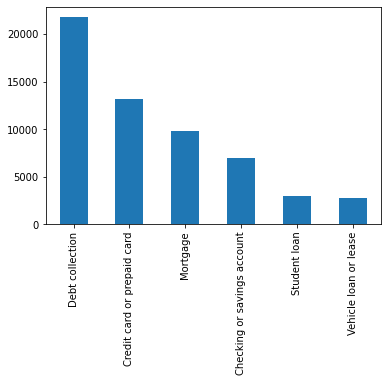

In [ ]:
df['Product'].value_counts().plot(kind='bar')

In [ ]:
df['Company'].value_counts()

CITIBANK, N.A.                           3226
CAPITAL ONE FINANCIAL CORPORATION        2711
BANK OF AMERICA, NATIONAL ASSOCIATION    2580
JPMORGAN CHASE & CO.                     2409
WELLS FARGO & COMPANY                    2001
                                         ... 
Asset Law Group, P.C.                       1
SFS, Inc                                    1
DAS ACQUISITION COMPANY, LLC                1
Investigative Concepts, Inc.                1
Cannon & Cannon Firm PC                     1
Name: Company, Length: 2197, dtype: int64

In [ ]:
complanints_df=df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints','Product':'product','Company':'company'})

In [ ]:
complanints_df

,complaints,product,company
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc."
...,...,...,...
57448,I am attempting to make a payment toward my st...,Student loan,"Nelnet, Inc."
57449,Received letter for {$480.00}. Original credit...,Debt collection,"The Receivable Management Services LLC, New Yo..."
57450,entire time 10 years until XX/XX/2020. XXXX ma...,Debt collection,"Convergent Resources, Inc."
57451,I am a customer with Wells Fargo Bank. Recentl...,Checking or savings account,WELLS FARGO & COMPANY


In [ ]:
pd.set_option('display.max_colwidth',-1)
complanints_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,complaints,product,company
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked and they never

In [ ]:
target= {'Debt collection':0,'Credit card or prepaid card':1,'Mortgage':2,'Checking or savings account':3,'Student loan':4,'Vehicle loan or lease':5}

In [ ]:
complanints_df['target']=complanints_df['product'].map(target)

In [ ]:
complanints_df

,complaints,product,company,target
0,"This auto loan was opened on XX/XX/2020 in XXXX, NC with BB & T in my name. I have NEVER been to North Carolina and I have NEVER been a resident. I have filed a dispute twice through my credit bureaus but both times BB & T has claimed that this is an accurate loan. Which I wasn't aware of until today. I have tried to contact BB & T multiple times but I have never gotten through to a live person. I do n't drive and I have never owned a car before. I didn't have any knowledge of this account until I checked XXXXXXXX XXXX and noticed it. I've tried twice to dispute it. Additionally I never received any bills or information about this account. This is my last resort in trying to remove this fraudulent loan off of my account.",Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,"In XXXX of 2019 I noticed a debt for {$620.00} on my credit which i believed was mine I thought speedy cash had bought one of my old debts and sold it to XXXX XXXX XXXX XXXX. I contacted XXXX XXXX XXXX XXXX and after several attempts of giving my full name, nothing came up in their system. I gave my social and the rep said the account popped up but DID NOT tell me that the account was under someone elses name and continued to let me make a payment. The payment was for {$120.00}. Confirmation number-XXXX. After realizing it was not my account, I called back to get my money back and inform them of the mistake. I was told i needed to mail them an FTC report and dispute letter to get my money back. I completed all of this and when i called again they said they transferred the account back to speedy cash for fraud review and I would need to contact them. After contacting them i was again told that i can not get my money back. The issue im having is this representative at XXXX XXXX played blind to obvious fraud and let an innocent person make a payment on someone elses debt and i want my money back.",Debt collection,CURO Intermediate Holdings,0
2,"As stated from Capital One, XXXX XX/XX/XXXX and XXXX 2018, My wife and I went to several car dealerships to request for a car loan to get a used car. However, according to their credit requirements unfortunately my credit score was insufficient for the car loan approval at that time. It seemed as though they pulled my credit report multiple times.",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,"Please see CFPB case XXXX. \n\nCapital One, in the letter they provided ( and attached to that case as their response ) said this : "" The funds were reversed and sent back to XXXX XXXX XXXX on XX/XX/XXXX ''. \n\nXXXX XXXX XXXX ( now XXXX XXXX ) has not received these funds. Staff at XXXX XXXX - and also staff at the account-holder 's business - have looked for return of my money ( {$650.00} ) and find nothing. \n\nCapital One needs to document - actually prove - they returned the funds, as stated in their letter. Capital One must provide electronic information, if the return was made that way, or document the paper check they sent back to XXXX XXXX. \n\nI've left 3 messages about this problem for the person who signed the letter ( XXXX ) from Capital One. I have received no call-backs. \n\nSummary : Capital One said they returned my money on XX/XX/XXXX : they did not. If they continue claim they did, then they need to prove that.",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,"This debt was incurred due to medical malpractice ( XXXX XXXX XXXX, XXXX, TX ). I asked the doctor to turn over my claim to his malpractice insurance company. This has cost me thousands of dollars to XXXX XXXX XXXX. I am still trying to collect damages from this doctor. He never responded and turned over me to collections Merchants and Professional Collection Bureau , Inc. I sent them a letter describing exactly this issue and instead of not contacting me and verifying my debt they start reporting this debt to the credit reporting agencies. They never verified the debt, like I asked

In [ ]:
X_train,X_test = train_test_split(complanints_df,test_size=0.6,random_state=111)

In [ ]:
X_train['product'].value_counts()

Debt collection                8720
Credit card or prepaid card    5297
Mortgage                       3809
Checking or savings account    2822
Student loan                   1236
Vehicle loan or lease          1097
Name: product, dtype: int64

In [ ]:
#stemmer= PorterStemmer()
stemmer= nltk.stem.SnowballStemmer('english')

In [ ]:
nltk.download('stopwords')
stop_words=set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenize(text):
  tokens=[word for word in nltk.word_tokenize(text)if(len(word) >3 and len(word.strip('Xx/'))>2 and len(re.sub('\d+','',word.strip('Xx/'))))]
  tokens=map(str.lower,tokens)
  stems=[stemmer.stem(item) for item in tokens if (item not in stop_words)]
  return stems

In [ ]:
vectorizer_tf= TfidfVectorizer(tokenizer =tokenize,stop_words=None,max_df=0.75,max_features=1000,lowercase=False,ngram_range=(1,2))
train_vectors=vectorizer_tf.fit_transform(X_train.complaints)

In [ ]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.4650653 , 0.        , ..., 0.        , 0.        ,
        0.08346433],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
vectorizer_tf.get_feature_names()

['0.00',
 '100.00',
 '1000.00',
 '200.00',
 '2000.00',
 '300.00',
 '500.00',
 'abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account bank',
 'account call',
 'account close',
 'account credit',
 'account inform',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advantag',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amex',
 'amount',
 'amount owe',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'around',
 

In [ ]:
test_vectors= vectorizer_tf.transform(X_test.complaints)

In [ ]:
X_train.shape

(22981, 4)

In [ ]:
train_df=pd.DataFrame(train_vectors.toarray(),columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)],axis=1)
train_df

,0.00,100.00,1000.00,200.00,2000.00,300.00,500.00,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,...,verif,verifi,victim,victim ident,violat,visa,visit,voicemail,wait,waiv,want,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134290,0.0,0.000000,0.0,0.0,0.059122,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.113348,0.093411,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.100168,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.044421,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1
1,0.0,0.000000,0.000000,0.127255,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223209,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.056387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049579,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.076869,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.084923,0.112738,0.000000,0.0,0.000000,0.051261,0.0,0.0,0.0,0.062024,0.0,0.000000,0.000000,0.0,0.0,0.000000,3
2,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064872,0.0,0.210364,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.128372,0.0,0.0,0.0,0.0,...,0.0,0.141182,0.0,0.0,0.000000,0.0,0.0,0.0,0.145166,0.0,0.0,0.0,0.128782,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1
3,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043657,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.192062,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.083427,0.0,0.239639,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.107026,0.0,0.0,0.000000,0
4,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056753,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.214992,0.318362,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22976,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.252835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.055023,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.058184,0.077241,0.000000,0.0,0.000000,0.105363,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,1
22977,0.0,0.000000,0.146029,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100872,0.0,0.163551,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
test_df=pd.DataFrame(test_vectors.toarray(),columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)],axis=1)
test_df

,0.00,100.00,1000.00,200.00,2000.00,300.00,500.00,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,...,verif,verifi,victim,victim ident,violat,visa,visit,voicemail,wait,waiv,want,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.087080,0.0,0.0,0.0,0.212382,0.0,0.348278,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.045424,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.043212,0.0,0.000000,0.0,0.086403,0.0,0.000000,0.0,0.0,0.079003,0.0,0.0,0.0,0.000000,0.0,0.00000,0.109978,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,3
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.124198,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,2
2,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.155816,0.0,0.0,0.0,0.000000,0.0,0.233696,0.0,0.0,0.0,0.0,0.205772,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1
3,0.095682,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.088530,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.058561,0.0,0.044815,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.037269,0.000000,0.0,0.0,0.045094,0.0,0.000000,0.0,0.000000,0.0,0.071166,4
4,0.000000,0.000000,0.0,0.000000,0.132589,0.0,0.0,0.0,0.079788,0.0,0.0,0.0,0.000000,0.0,0.039889,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.128279,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34467,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.044330,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.204734,0.0,0.0,0.0,0.000000,0.087724,0.0,0.0,0.0,0.0,...,0.113646,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0
34468,0.000000,0.000000,0.0,0.063658,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.099040,0.0,0.101507,0.0,0.0,0.0,0.0,0.000000,0.055976,0.0,0.0,0.0,0.062624,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.

In [ ]:
h2o_train_df=h2o.H2OFrame(train_df)
h2o_test_df=h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
h2o_train_df.types

{'0.00': 'real',
 '100.00': 'real',
 '1000.00': 'real',
 '200.00': 'real',
 '2000.00': 'real',
 '300.00': 'real',
 '500.00': 'real',
 'abil': 'real',
 'abl': 'real',
 'absolut': 'real',
 'abus': 'real',
 'accept': 'real',
 'access': 'real',
 'accord': 'real',
 'account': 'real',
 'account account': 'real',
 'account balanc': 'real',
 'account bank': 'real',
 'account call': 'real',
 'account close': 'real',
 'account credit': 'real',
 'account inform': 'real',
 'account number': 'real',
 'account open': 'real',
 'account report': 'real',
 'account would': 'real',
 'accru': 'real',
 'acct': 'real',
 'accur': 'real',
 'acknowledg': 'real',
 'action': 'real',
 'activ': 'real',
 'actual': 'real',
 'ad': 'real',
 'addit': 'real',
 'address': 'real',
 'adjust': 'real',
 'admit': 'real',
 'advanc': 'real',
 'advantag': 'real',
 'advertis': 'real',
 'advis': 'real',
 'affect': 'real',
 'affidavit': 'real',
 'afford': 'real',
 'agenc': 'real',
 'agent': 'real',
 'agre': 'real',
 'agreement': 'r

In [ ]:
h2o_train_df['target']=h2o_train_df['target'].asfactor()
h2o_test_df['target']=h2o_test_df['target'].asfactor()

In [ ]:
aml= H2OAutoML(max_models=10,seed=10,exclude_algos=["StackedEnsemble"],verbosity='info',nfolds=0,balance_classes=True,max_after_balance_size=0.3)

In [ ]:
x=vectorizer_tf.get_feature_names()
y='target'

In [ ]:
aml.train(x=x,y=y,training_frame=h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
20:15:20.987: Project: AutoML_20200825_201520982
20:15:20.989: Cross-validation disabled by user: no fold column nor nfolds > 1.
20:15:21.0: Setting stopping tolerance adaptively based on the training frame: 0.006596529950565859
20:15:21.0: Build control seed: 10
20:15:21.1: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
20:15:23.563: training frame: Frame key: automl_training_py_1_sid_a5c1    cols: 1001    rows: 20607  chunks: 27    size: 17153881  checksum: -5281035211987943119
20:15:23.573: validation frame: Frame key: py_2_sid_a5c1    cols: 1001    rows: 34472  chunks: 40    size: 28821604  checksum: -1159730464431736559
20:15:23.677: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_a5c1    cols: 1001    rows: 2374  chunks: 27    size: 3818158  checksum: -3604939037459685681
20:15:23.677: blending frame: NULL
20:15:23.677: response co

In [ ]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20200825_201520,0.147367,0.354366,0.319715,0.102218
XGBoost_3_AutoML_20200825_201520,0.150678,0.353107,0.323928,0.104929
XGBoost_2_AutoML_20200825_201520,0.150975,0.360939,0.322446,0.103971
GBM_3_AutoML_20200825_201520,0.153405,0.405233,0.342262,0.117143
GBM_2_AutoML_20200825_201520,0.158065,0.423165,0.351357,0.123452
GBM_1_AutoML_20200825_201520,0.159063,0.41856,0.353988,0.125308
GBM_5_AutoML_20200825_201520,0.159304,0.409154,0.343376,0.117907
GBM_4_AutoML_20200825_201520,0.165357,0.430232,0.352697,0.124395
GLM_1_AutoML_20200825_201520,0.17369,0.412124,0.347938,0.121061
DRF_1_AutoML_20200825_201520,0.295295,0.62484,0.458598,0.210312


In [ ]:
pred=aml.leader.predict(h2o_test_df)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [ ]:
model_ids=list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out= h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [ ]:
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20200825_201520


Model Summary: 


,,number_of_trees
0,,80.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.031035086598757866
RMSE: 0.17616777968390776
LogLoss: 0.11764991004912542
Mean Per-Class Error: 0.03584259840206982

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,7720.0,68.0,25.0,12.0,8.0,16.0,0.016435,"129 / 7,849"
1,111.0,4586.0,5.0,23.0,2.0,2.0,0.030239,"143 / 4,729"
2,35.0,25.0,3333.0,5.0,0.0,2.0,0.019706,"67 / 3,400"
3,29.0,25.0,4.0,2490.0,0.0,2.0,0.023529,"60 / 2,550"
4,32.0,20.0,3.0,1.0,1035.0,1.0,0.052198,"57 / 1,092"
5,38.0,24.0,3.0,4.0,3.0,915.0,0.072948,72 / 987
6,7965.0,4748.0,3373.0,2535.0,1048.0,938.0,0.025622,"528 / 20,607"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.974378
1,2,0.994419
2,3,0.997962
3,4,0.999321
4,5,0.999903
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.10333953567757044
RMSE: 0.32146467251872396
LogLoss: 0.3560002002725734
Mean Per-Class Error: 0.1602033411365875

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,12071.0,451.0,183.0,102.0,110.0,135.0,0.075161,"981 / 13,052"
1,567.0,6868.0,51.0,336.0,17.0,57.0,0.130193,"1,028 / 7,896"
2,209.0,97.0,5515.0,43.0,46.0,80.0,0.079299,"475 / 5,990"
3,158.0,431.0,43.0,3525.0,7.0,17.0,0.156900,"656 / 4,181"
4,166.0,62.0,56.0,5.0,1388.0,37.0,0.190198,"326 / 1,714"
5,290.0,126.0,75.0,11.0,38.0,1099.0,0.329469,"540 / 1,639"
6,13461.0,8035.0,5923.0,4022.0,1606.0,1425.0,0.116210,"4,006 / 34,472"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.883790
1,2,0.961215
2,3,0.983407
3,4,0.993183
4,5,0.997969
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2020-08-25 20:15:24,0.073 sec,0.0,0.833333,1.791759,0.835008,0.833333,1.791759,0.826236
1,,2020-08-25 20:15:31,7.806 sec,5.0,0.462734,0.637200,0.121949,0.487716,0.699731,0.153545
2,,2020-08-25 20:15:35,11.158 sec,10.0,0.356122,0.410553,0.099529,0.400391,0.505905,0.141883
3,,2020-08-25 20:15:38,14.638 sec,15.0,0.310550,0.317990,0.086233,0.368393,0.436345,0.135907
4,,2020-08-25 20:15:42,18.082 sec,20.0,0.284953,0.270531,0.074780,0.353530,0.405839,0.129990
5,,2020-08-25 20:15:46,22.042 sec,25.0,0.268183,0.241443,0.066482,0.345058,0.389511,0.127785
6,,2020-08-25 20:15:50,25.908 sec,30.0,0.254267,0.219102,0.060028,0.339019,0.378689,0.124362
7,,2020-08-25 20:15:53,29.477 sec,35.0,0.242876,0.201384,0.054205,0.334835,0.371774,0.122476
8,,2020-08-25 20:15:57,33.826 sec,40.0,0.232645,0.186807,0.049207,0.331940,0.367325,0.120126
9,,2020-08-25 20:16:01,37.863 sec,45.0,0.223284,0.173897,0.044208,0.329819,0.363921,0.119749



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,debt,7337.685547,1.000000,0.096167
1,mortgag,6361.130859,0.866912,0.083368
2,card,5816.252441,0.792655,0.076227
3,loan,3343.449219,0.455654,0.043819
4,bank,3027.660645,0.412618,0.039680
5,collect,2808.822754,0.382794,0.036812
6,credit card,2323.673584,0.316677,0.030454
7,account,1911.862671,0.260554,0.025057
8,student,1792.484131,0.244285,0.023492
9,payment,1723.106567,0.234830,0.022583



See the whole table with table.as_data_frame()


In [ ]:
out.convert_H2OXGBoostParams_2_XGBoostParams

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20200825_201520


Model Summary: 


,,number_of_trees
0,,80.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.031035086598757866
RMSE: 0.17616777968390776
LogLoss: 0.11764991004912542
Mean Per-Class Error: 0.03584259840206982

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,7720.0,68.0,25.0,12.0,8.0,16.0,0.016435,"129 / 7,849"
1,111.0,4586.0,5.0,23.0,2.0,2.0,0.030239,"143 / 4,729"
2,35.0,25.0,3333.0,5.0,0.0,2.0,0.019706,"67 / 3,400"
3,29.0,25.0,4.0,2490.0,0.0,2.0,0.023529,"60 / 2,550"
4,32.0,20.0,3.0,1.0,1035.0,1.0,0.052198,"57 / 1,092"
5,38.0,24.0,3.0,4.0,3.0,915.0,0.072948,72 / 987
6,7965.0,4748.0,3373.0,2535.0,1048.0,938.0,0.025622,"528 / 20,607"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.974378
1,2,0.994419
2,3,0.997962
3,4,0.999321
4,5,0.999903
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.10333953567757044
RMSE: 0.32146467251872396
LogLoss: 0.3560002002725734
Mean Per-Class Error: 0.1602033411365875

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,12071.0,451.0,183.0,102.0,110.0,135.0,0.075161,"981 / 13,052"
1,567.0,6868.0,51.0,336.0,17.0,57.0,0.130193,"1,028 / 7,896"
2,209.0,97.0,5515.0,43.0,46.0,80.0,0.079299,"475 / 5,990"
3,158.0,431.0,43.0,3525.0,7.0,17.0,0.156900,"656 / 4,181"
4,166.0,62.0,56.0,5.0,1388.0,37.0,0.190198,"326 / 1,714"
5,290.0,126.0,75.0,11.0,38.0,1099.0,0.329469,"540 / 1,639"
6,13461.0,8035.0,5923.0,4022.0,1606.0,1425.0,0.116210,"4,006 / 34,472"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.883790
1,2,0.961215
2,3,0.983407
3,4,0.993183
4,5,0.997969
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2020-08-25 20:15:24,0.073 sec,0.0,0.833333,1.791759,0.835008,0.833333,1.791759,0.826236
1,,2020-08-25 20:15:31,7.806 sec,5.0,0.462734,0.637200,0.121949,0.487716,0.699731,0.153545
2,,2020-08-25 20:15:35,11.158 sec,10.0,0.356122,0.410553,0.099529,0.400391,0.505905,0.141883
3,,2020-08-25 20:15:38,14.638 sec,15.0,0.310550,0.317990,0.086233,0.368393,0.436345,0.135907
4,,2020-08-25 20:15:42,18.082 sec,20.0,0.284953,0.270531,0.074780,0.353530,0.405839,0.129990
5,,2020-08-25 20:15:46,22.042 sec,25.0,0.268183,0.241443,0.066482,0.345058,0.389511,0.127785
6,,2020-08-25 20:15:50,25.908 sec,30.0,0.254267,0.219102,0.060028,0.339019,0.378689,0.124362
7,,2020-08-25 20:15:53,29.477 sec,35.0,0.242876,0.201384,0.054205,0.334835,0.371774,0.122476
8,,2020-08-25 20:15:57,33.826 sec,40.0,0.232645,0.186807,0.049207,0.331940,0.367325,0.120126
9,,2020-08-25 20:16:01,37.863 sec,45.0,0.223284,0.173897,0.044208,0.329819,0.363921,0.119749



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,debt,7337.685547,1.000000,0.096167
1,mortgag,6361.130859,0.866912,0.083368
2,card,5816.252441,0.792655,0.076227
3,loan,3343.449219,0.455654,0.043819
4,bank,3027.660645,0.412618,0.039680
5,collect,2808.822754,0.382794,0.036812
6,credit card,2323.673584,0.316677,0.030454
7,account,1911.862671,0.260554,0.025057
8,student,1792.484131,0.244285,0.023492
9,payment,1723.106567,0.234830,0.022583



See the whole table with table.as_data_frame()


<bound method H2OEstimator.convert_H2OXGBoostParams_2_XGBoostParams of >

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
xgb_clf= xgb.XGBClassifier(n_estimstors=100,learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10,**{"updater":"grow_gpu"})

In [ ]:
xgb_clf.fit(train_vectors,X_train['target'])

[21:07:05] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100,
              n_estimstors=100, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, updater='grow_gpu', verbosity=1)

In [ ]:
predictions= xgb_clf.predict(test_vectors)

In [ ]:
cm= confusion_matrix(X_test['target'],predictions)
print(cm)

[[11934   524   192   130   129   143]
 [  796  6670    41   332     7    50]
 [  363   111  5373    64    32    47]
 [  291   408    69  3388     7    18]
 [  229    71    53     4  1328    29]
 [  333   146    62    29    31  1038]]


In [ ]:
print('classification report\n',classification_report(X_test['target'],predictions))

classification report
               precision    recall  f1-score   support

           0       0.86      0.91      0.88     13052
           1       0.84      0.84      0.84      7896
           2       0.93      0.90      0.91      5990
           3       0.86      0.81      0.83      4181
           4       0.87      0.77      0.82      1714
           5       0.78      0.63      0.70      1639

    accuracy                           0.86     34472
   macro avg       0.86      0.81      0.83     34472
weighted avg       0.86      0.86      0.86     34472



In [ ]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                                      np.unique(X_train['target']),
                                                      X_train['target']
))

In [ ]:
class_weights

[0.43923929663608563,
 0.7230822478132276,
 1.0055570140894372,
 1.357252539570045,
 3.0988403451995685,
 3.4914919477362503]

In [ ]:
weights=np.ones(X_train.shape[0],dtype='float')
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [82]:
for i, val in enumerate(X_train['target']):
  weights[i]= class_weights[val]

In [83]:
xgb_clf= xgb.XGBClassifier(n_estimstors=100,learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10,**{"updater":"grow_gpu"})

In [84]:
xgb_clf.fit(train_vectors,X_train['target'],sample_weight=weights)

[21:24:18] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100,
              n_estimstors=100, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, updater='grow_gpu', verbosity=1)

In [85]:
predictions=xgb_clf.predict(test_vectors)

In [86]:
cm= confusion_matrix(X_test['target'],predictions)
print(cm)

[[11120   595   258   324   260   495]
 [  476  6404    65   583    11   357]
 [  131    51  5303    84   188   233]
 [  115   296    51  3636    16    67]
 [   91    14    16    10  1460   123]
 [  148    50    28    36    66  1311]]


In [87]:
print('classification report\n',classification_report(X_test['target'],predictions))

classification report
               precision    recall  f1-score   support

           0       0.92      0.85      0.88     13052
           1       0.86      0.81      0.84      7896
           2       0.93      0.89      0.91      5990
           3       0.78      0.87      0.82      4181
           4       0.73      0.85      0.79      1714
           5       0.51      0.80      0.62      1639

    accuracy                           0.85     34472
   macro avg       0.79      0.84      0.81     34472
weighted avg       0.86      0.85      0.85     34472

